## Quantile Regression

- In all ML models, we are trying to make a prediction. And usually, we are trying to create a model that gives us the best prediction of the conditional mean. 
    - That is, we usually want to predict $E[y | X]$, or the average value of the dependent varaible $y$ conditional on the $X$ covariates

- This is the reason why the usual MSE loss function is symmetric; we want to punish "wrongness" in either direction equally
    - if the true value is 10, predicting 8 is equally wrong as predicting 12

- Under some circumstances, however, this is not ideal. Why?
    - Optimising for the average is not great if you have skewed errors or heteroscedastic errors. Then even if your average error is minimised, you can be wrong for most observations
    - If you have some massive outliers, these will have disproportionate weight on the eventual regression
    - Sometimes, you want relationship between covariates and outcomes to be flexible across different quantiles
    - In some circumstances, you care more about the predictions across a range of percentiles, than a point distribution (i.e. what is the prediction of demand at 90th percentile? 50th?)

- Quantile regression addresses this issue because
    - Its prediction is based on medians instead of means
    - You can predict for a range of percentiles instead of a single point prediction

## Mechanics of Quantile Regression

- How does Quantile Regression achieve these? With 1 simple tweak; the **pinball loss function**!!

- The pinball loss is as follows

$$\begin{aligned}
    \rho(y, \hat{y}) &= \begin{Bmatrix}
        \tau u & \forall u \ge 0  \\
        (\tau - 1) u & \forall u < 0 
    \end{Bmatrix} \\ \\

    &\text{where} \\
    &\qquad u = y - \hat{y} \\
    &\qquad \tau \text{ is user provided constant}
\end{aligned}$$

- That is, we provide the desired percentile $\tau$, and this loss function will magically produce an output that predicts the $\tau$ percentile!

- Let's study this intuition a little:
    - Suppose we have $\tau = 0.8$ and $y = 10$. Let's study the cases where $\hat{y_1} = 8$ and $\hat{y_2} = 12$
        $$\begin{aligned}
            u_1 &= y - \hat{y_1} = 10 - 8 = 2 \\
            u_2 &= y - \hat{y_2} = 10 - 12 = -2 \\ \\
        \end{aligned}$$
        
        - Since we are interested in a relatively higher percentile (0.8), we disproportionately punish underprediction. When $y >= \hat{y}$, we multiply the mean absolute error by 0.8; $0.8 * (10 - 8) = 1.6$
        
        - But when $y < \hat{y}$, we only multiply it by $(0.8 - 1)$, giving us $-0.2 * (10 - 12) = 0.4$

        - So clearly, when $\tau$ is high, we penalise under-prediction more

        - And the converse is true when $\tau$ is low; we penalise over-prediction!


### FAQ: Prove pinball loss produces a percentile prediction, vs MSE producing a mean prediction?

#### Show MSE produces mean prediction

- MSE is defined as

$$\begin{aligned}
    \text{MSE} &= E[(y - \hat{y})^2] \\ 
    &= \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y})^2
\end{aligned}$$

- We want to find $\hat{y}$ such that
$$\begin{aligned}
    \frac{\delta}{\delta \hat{y}} (\text{MSE}) &= 0 \\
    &= \frac{\delta}{\delta \hat{y}} (\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y})^2) \\
    &= \frac{1}{n} \cdot -2 \cdot \sum_{i=1}^{n} (y_i - \hat{y}) \\ \\

    \therefore \frac{-2}{n} \cdot \sum_{i=1}^{n} (y_i - \hat{y}) &= 0 \\
    \sum_{i=1}^{n} (y_i - \hat{y}) &= 0 \\
    \sum_{i=1}^{n} (y_i) - n \cdot \hat{y} &= 0 \\
    \hat{y} = \frac{\sum_{i=1}^{n} (y_i)}{n}
\end{aligned}$$

- As we can see, the optimal value for $\hat{y}$ is $\frac{\sum_{i=1}^{n} (y_i)}{n}$, which is the average value of $y$

#### Show pinball loss produces quartile prediction

- Pinball loss is given by

$$\begin{aligned}
    \rho(y, \hat{y}) &= \begin{Bmatrix}
        \tau u & \forall u \ge 0  \\
        (\tau - 1) u & \forall u < 0 
    \end{Bmatrix} \\ \\

    \text{where}& \\
    & u = y - \hat{y}

\end{aligned}$$

- Similar to MSE, we want to find $\hat{y}$ that minimises the expected loss 

$$\begin{aligned}
    E[\rho(y, \hat{y})] &= E[\tau \cdot u \cdot I(u \ge 0) + (\tau-1) \cdot u \cdot I(u < 0)] \\ 
    &= E[\tau \cdot u \cdot I(u \ge 0)] + E[(\tau-1) \cdot u \cdot I(u < 0)] \\
    &= \int_{\hat{y}}^{\inf} \tau \cdot (y - \hat{y}) f(y) + \int_{-\inf}^{\hat{y}} (\tau-1) \cdot (y - \hat{y}) f(y) & \text{ where} f(y) \text{ is PDF of y} \\

    \\ \\
    \frac{\delta}{\delta \hat{y}} E[\rho(y, \hat{y})] &= \frac{\delta}{\delta \hat{y}} \int_{\hat{y}}^{\inf} \tau \cdot (y - \hat{y}) f(y) + \frac{\delta}{\delta \hat{y}}  \int_{-\inf}^{\hat{y}} (\tau-1) \cdot (y - \hat{y}) f(y) \\
    &= -\tau \int_{\hat{y}}^{\inf}  f(y) + (1 - \tau) \int_{-\inf}^{\hat{y}}  f(y) \\
    &= -\tau (1 - F(\hat{y})) + (1 - \tau) F(\hat{y}) & \text{ integral of f(y) from -inf to } \hat{y} \text{ is CDF } F(\hat{y}) \\
    &= -\tau + F(\hat{y}) \tau + F(\hat{y}) - \tau F(\hat{y}) \\
    &= F(\hat{y}) -\tau \\
    &= 0 \\ \\

    \therefore F(\hat{y}) &= P(y \le \hat{y}) \\ &= \tau

\end{aligned}$$

- Therefore, at the point where $E[\rho(y, \hat{y})]$ is minimised, it must be true that $\tau$ is equal to the CDF at $\hat{y}$, or equivalently, $\hat{y} = CDF^{-1}(\tau)$
    - That is, the prediction $\hat{y}$ takes on the value at the $\tau$-th percentile when the pinball loss is minimised

## Implementing Quantile Regression from Scratch

- To implement quantile regression, let's use gradient descent. 

- Recall that for gradient descent, we need to know $\frac{\partial \rho}{\partial \beta}$, or the change in the loss function for a given change in coefficient

$$\begin{aligned}
    \frac{\partial \rho}{\partial \beta} &= \frac{\partial \rho}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial \beta}
\end{aligned}$$

- For a pinball loss, $\frac{\partial \rho}{\partial \hat{y}}$ is 

$$\begin{aligned}
    \frac{\partial \rho}{\partial \hat{y}} &= \frac{\partial}{\partial \hat{y}} \begin{Bmatrix}
        \tau u & \forall u \ge 0  \\
        (\tau - 1) u & \forall u < 0 
    \end{Bmatrix}  \\
    &= \frac{\partial}{\partial \hat{y}} \begin{Bmatrix}
        \tau (y - \hat{y}) & \forall u \ge 0  \\
        (\tau - 1) (y - \hat{y}) & \forall u < 0 
    \end{Bmatrix} \\
    &= \begin{Bmatrix}
        -\tau & \forall u \ge 0  \\
        (1 - \tau) & \forall u < 0 
    \end{Bmatrix} 
\end{aligned}$$

- Since we assume a linear regression, $\frac{\partial \hat{y}}{\partial \beta}$ is just $x$

- Therefore

$$\begin{aligned}
    \frac{\partial \rho}{\partial \beta} &= \frac{\partial \rho}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial \beta} \\
    &= \begin{Bmatrix}
        -\tau \cdot x & \forall u \ge 0  \\
        (1 - \tau) \cdot x & \forall u < 0 
    \end{Bmatrix}
\end{aligned}$$

- Now, recall that gradient descent updates the coefficients in the opposite direction of $\frac{\partial \rho}{\partial \beta}$. That is, if increasing $\beta$ increases the loss $\rho$ (i.e. $\frac{\partial \rho}{\partial \beta} > 0$), then we want to adjust our coefficients $\beta$ in the opposite direction. The typical update is:

$$\begin{aligned}
    \beta_{\text{new}} &= \beta_{\text{curr}} - \eta \frac{\partial \rho}{\partial \beta}
\end{aligned}$$

In [453]:
import numpy as np

class MyQuantileRegressor:
    def __init__(self, quantile: float, lr: float, max_iter: int, tol: float, fit_intercept: bool):
        self.quantile = quantile
        self.lr: float = lr
        self.max_iter = max_iter
        self.tol = tol
        self.fit_intercept = fit_intercept

    def pinball_loss(self, residuals: np.array) -> np.array:
        '''
        (m x n) @ (n x 1) = m x 1
        '''
        # loss = np.mean(np.where(residuals >= 0, self.quantile * residuals, (self.quantile-1)*residuals))
        loss = residuals.reshape(1,-1) @ (((residuals >= 0) * self.quantile) + (residuals < 0) * (self.quantile-1))
        return loss
        
    def pinball_loss_gradient(self, X, residuals: np.array):
        '''
        (m * n) @ (n * 1) = m * 1
        '''
        grads = X.T @ (((residuals >= 0) * -self.quantile) + ((residuals < 0) * (1-self.quantile))).reshape(-1, 1)
        return grads
        
    def fit(self, X, y):
        n_obs, n_feats = X.shape
        if self.fit_intercept:
            X = np.concat([X, np.ones((n_obs,1))], axis=1)
            n_obs, n_feats = X.shape
        
        self.weights_curr = np.random.randn(n_feats, 1)

        ## Gradient descent
        for epoch in range(self.max_iter):
            ypred = X @ self.weights_curr
            residuals = y.reshape(-1,) - ypred.reshape(-1,)

            gradients= self.pinball_loss_gradient(X, residuals)

            self.weights_new = self.weights_curr - (self.lr * gradients)

            if np.linalg.norm(self.weights_new - self.weights_curr, 2) <= self.tol:
                print(f"Stopping early as epoch {epoch} because L2 norm of weight diff is {np.linalg.norm(self.weights_new - self.weights_curr, 2)} < {self.tol=}")
                break
            
            self.weights_curr = self.weights_new

            # if epoch % 10 == 0:
            #     print(f"Loss: {self.pinball_loss(residuals)}")
        
        return self
            
    def predict(self, X):
        if self.fit_intercept:
            n_obs, n_feats = X.shape
            X = np.concat([X, np.ones((n_obs,1))], axis=1)
        return (X @ self.weights_curr).reshape(-1,)


In [454]:
from sklearn.datasets import make_regression
from sklearn.linear_model import QuantileRegressor, LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

rng = np.random.RandomState(42)
xsingle = np.linspace(start=0, stop=10, num=100)
xrepeat = np.repeat(xsingle, 5)

ytrue_single = 10 + 0.5 * xsingle
ytrue_repeat = 10 + 0.5 * xrepeat
ynormal_repeat = ytrue_repeat + rng.normal(loc=0, scale=0.5 + 0.5 * xrepeat, size=xrepeat.shape[0])

In [455]:
# plt.plot(xrepeat, ynormal_repeat)

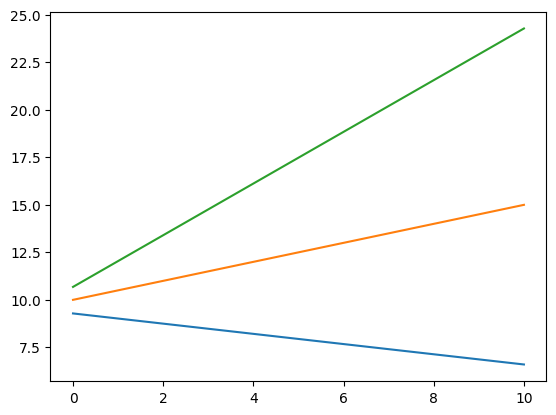

In [456]:
qr_ub = QuantileRegressor(quantile=0.95, alpha=0, fit_intercept=True)
qr_lb = QuantileRegressor(quantile=0.05, alpha=0, fit_intercept=True)

qr_ub.fit(xrepeat.reshape(-1,1), ynormal_repeat)
qr_lb.fit(xrepeat.reshape(-1,1), ynormal_repeat)

plt.plot(xsingle, qr_lb.predict(xsingle.reshape(-1,1)))
plt.plot(xsingle, ytrue_single)
plt.plot(xsingle, qr_ub.predict(xsingle.reshape(-1,1)))

In [457]:
mqr_ub = MyQuantileRegressor(quantile=0.95, lr=1e-3, max_iter=1000, tol=1e-3, fit_intercept=True)
mqr_lb = MyQuantileRegressor(quantile=0.05, lr=1e-3, max_iter=1000, tol=1e-3, fit_intercept=True)
mqr_lb.fit(xrepeat.reshape(-1,1), ynormal_repeat)
mqr_ub.fit(xrepeat.reshape(-1,1), ynormal_repeat)

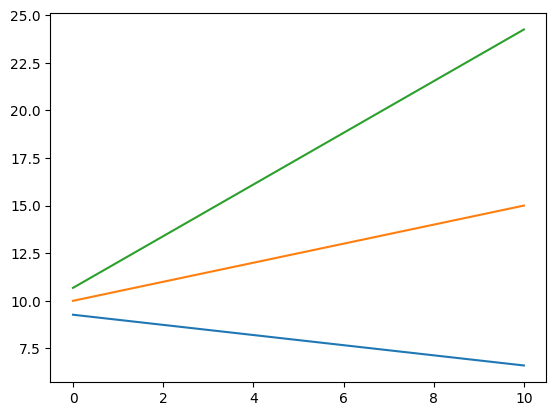

In [458]:
plt.plot(xsingle, mqr_lb.predict(xsingle.reshape(-1,1)))
plt.plot(xsingle, ytrue_single)
plt.plot(xsingle, mqr_ub.predict(xsingle.reshape(-1,1)))

## Basic Quantile Regression use case

- As discussed in the introduction, quantile regression becomes important when we need a plausible range of predictions, instead of a point prediction (i.e. quantifying prediction uncertainty)

- https://scikit-learn.org/stable/auto_examples/linear_model/plot_quantile_regression.html

- We'll generate a toy dataset to show how quantile regression can be useful

In [13]:
import numpy as np
import matplotlib.pyplot as plt

In [14]:
x = np.linspace(start=0, stop=10, num=100)
X = x[:, np.newaxis]
y_true_mean = 10 + 0.5 * x

- From the linear relationship above, we add some noise. 
    - In the first case, we add random symmetric white noise (normally distributed)
    - In the second, we add some asymmetric noise (from pareto distribution)

In [3]:
y_normal = y_true_mean + np.random.normal(loc=0, scale=0.5 + 0.5 * x, size=x.shape[0])
a = 5
## Correct by 1 / (a - 1) shift the array downwards so it is "around" 0, though asymmetric
y_pareto = y_true_mean + 10 * (np.random.pareto(a, size=x.shape[0]) - 1 / (a - 1))

- Let's take a look at how these distributions end up. The charts show the values after the noise is added, and the histogram shows the distribution of residuals from the true mean

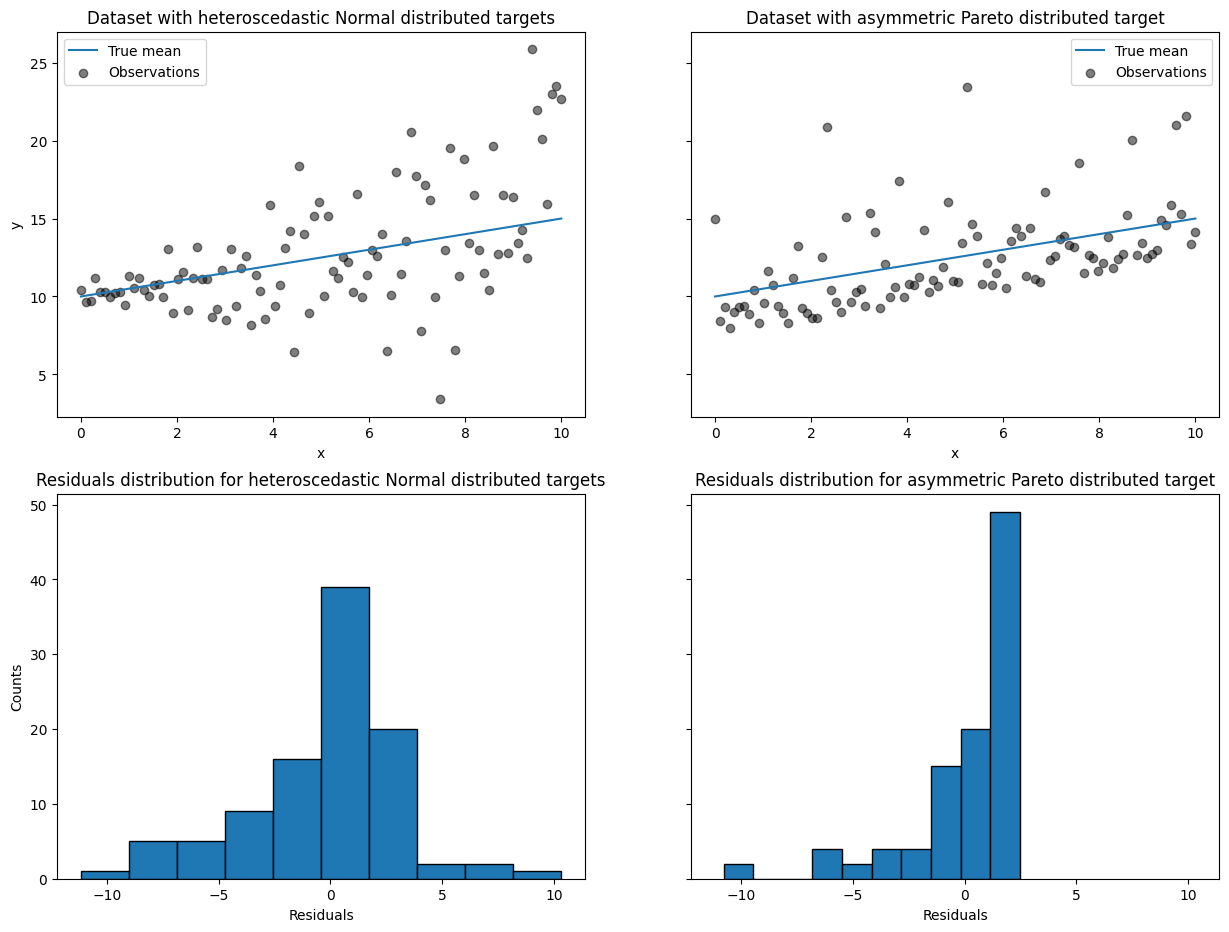

In [6]:
import matplotlib.pyplot as plt

_, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11), sharex="row", sharey="row")

axs[0, 0].plot(x, y_true_mean, label="True mean")
axs[0, 0].scatter(x, y_normal, color="black", alpha=0.5, label="Observations")
axs[1, 0].hist(y_true_mean - y_normal, edgecolor="black")


axs[0, 1].plot(x, y_true_mean, label="True mean")
axs[0, 1].scatter(x, y_pareto, color="black", alpha=0.5, label="Observations")
axs[1, 1].hist(y_true_mean - y_pareto, edgecolor="black")

axs[0, 0].set_title("Dataset with heteroscedastic Normal distributed targets")
axs[0, 1].set_title("Dataset with asymmetric Pareto distributed target")
axs[1, 0].set_title(
    "Residuals distribution for heteroscedastic Normal distributed targets"
)
axs[1, 1].set_title("Residuals distribution for asymmetric Pareto distributed target")
axs[0, 0].legend()
axs[0, 1].legend()
axs[0, 0].set_ylabel("y")
axs[1, 0].set_ylabel("Counts")
axs[0, 1].set_xlabel("x")
axs[0, 0].set_xlabel("x")
axs[1, 0].set_xlabel("Residuals")
_ = axs[1, 1].set_xlabel("Residuals")

- Now that we have visualised our data, let's see how the quantile regression predicts. For the 5%, 50% and 95% quantiles, we fit and make a prediction. 

- We also identify where the true value falls below the 5th or above the 95th percentiles, and flag these as "outliers"

- As expected, approximately 10% of "outliers" are below 5th or above 95th percentiles, proving that the quantile regression indeed predicts the quantile bounds!

- Since errors are symmetric, we should expect the mean and median predictions to be quite similar

In [47]:
from sklearn.linear_model import QuantileRegressor

quantiles = [0.05, 0.5, 0.95] ##predict 5%, 50% and 95% quantiles
predictions = {}
out_bounds_predictions = np.zeros_like(y_true_mean, dtype=np.bool_)

for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, alpha=0) 
    y_pred = qr.fit(X, y_normal).predict(X) 
    predictions[quantile] = y_pred

## Mark index where the true value exceeds the 5th or 95th percentile prediction
out_bounds_predictions = np.array([
    True if (minpred > trueval) or (maxpred < trueval) else False 
    for minpred, maxpred, trueval 
    in zip(predictions.get(min(quantiles)), predictions.get(max(quantiles)), y_normal)
])

sum(out_bounds_predictions) ## Approximately 10% of observations are above 95th or below 5th percentiles!

np.int64(9)

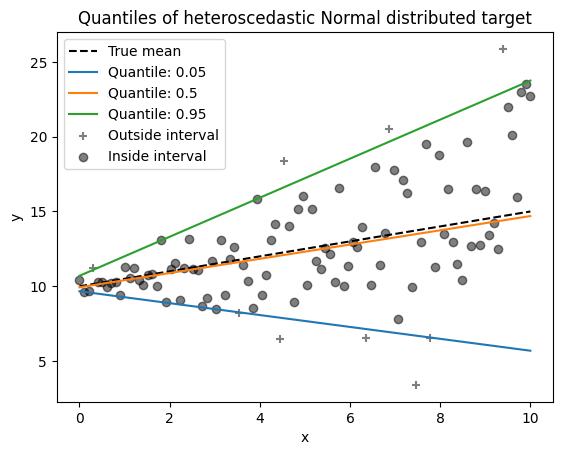

In [48]:
plt.plot(X, y_true_mean, color="black", linestyle="dashed", label="True mean")

for quantile, y_pred in predictions.items():
    plt.plot(X, y_pred, label=f"Quantile: {quantile}")

plt.scatter(
    x[out_bounds_predictions],
    y_normal[out_bounds_predictions],
    color="black",
    marker="+",
    alpha=0.5,
    label="Outside interval",
)

plt.scatter(
    x[~out_bounds_predictions],
    y_normal[~out_bounds_predictions],
    color="black",
    alpha=0.5,
    label="Inside interval",
)

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
_ = plt.title("Quantiles of heteroscedastic Normal distributed target")

- We do the same thing using the array with the pareto errors. 

- Now that errors are not symmetric, we should expect a difference between the true mean and median predictions

- Similarly, while the 5th and 95th quantile lines are symmetric about the median for the normal distribution case, we should expect some asymmetry with the pareto distribution

- But what should be consistent is that ~10% of points should be "outliers" compared to the region between 5th and 95th percentiles!

In [58]:
quantiles = [0.05, 0.5, 0.95]
predictions = {}
out_bounds_predictions = np.zeros_like(y_true_mean, dtype=np.bool_)
for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, alpha=0)
    y_pred = qr.fit(X, y_pareto).predict(X)
    predictions[quantile] = y_pred

## Mark index where the true value exceeds the 5th or 95th percentile prediction
out_bounds_predictions = np.array([
    True if (minpred > trueval) or (maxpred < trueval) else False 
    for minpred, maxpred, trueval 
    in zip(predictions.get(min(quantiles)), predictions.get(max(quantiles)), y_pareto)
])

sum(out_bounds_predictions) ## Approximately 10% of observations are above 95th or below 5th percentiles!

np.int64(8)

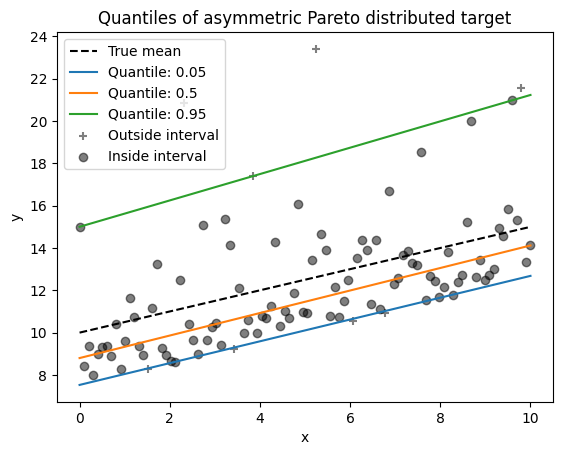

In [59]:
plt.plot(X, y_true_mean, color="black", linestyle="dashed", label="True mean")

for quantile, y_pred in predictions.items():
    plt.plot(X, y_pred, label=f"Quantile: {quantile}")

plt.scatter(
    x[out_bounds_predictions],
    y_pareto[out_bounds_predictions],
    color="black",
    marker="+",
    alpha=0.5,
    label="Outside interval",
)
plt.scatter(
    x[~out_bounds_predictions],
    y_pareto[~out_bounds_predictions],
    color="black",
    alpha=0.5,
    label="Inside interval",
)

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
_ = plt.title("Quantiles of asymmetric Pareto distributed target")

- Finally, as we discuss in the theory above, LinearRegression focuses on minimising the **mean squared error**, while QuantileRegression focuses on minimising the **mean absolute error**! This is evident in both the normal and pareto distributions

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

linear_regression = LinearRegression()
quantile_regression = QuantileRegressor(quantile=0.5, alpha=0)

y_pred_lr = linear_regression.fit(X, y_pareto).predict(X)
y_pred_qr = quantile_regression.fit(X, y_pareto).predict(X)

print(
    f"""Training error (in-sample performance)
    {linear_regression.__class__.__name__}:
    MAE = {mean_absolute_error(y_pareto, y_pred_lr):.3f}
    MSE = {mean_squared_error(y_pareto, y_pred_lr):.3f}
    {quantile_regression.__class__.__name__}:
    MAE = {mean_absolute_error(y_pareto, y_pred_qr):.3f}
    MSE = {mean_squared_error(y_pareto, y_pred_qr):.3f}
    """
)

Training error (in-sample performance)
    LinearRegression:
    MAE = 1.862
    MSE = 6.629
    QuantileRegressor:
    MAE = 1.683
    MSE = 7.492
    


In [64]:
from sklearn.model_selection import cross_validate

cv_results_lr = cross_validate(
    linear_regression,
    X,
    y_pareto,
    cv=3,
    scoring=["neg_mean_absolute_error", "neg_mean_squared_error"],
)
cv_results_qr = cross_validate(
    quantile_regression,
    X,
    y_pareto,
    cv=3,
    scoring=["neg_mean_absolute_error", "neg_mean_squared_error"],
)
print(
    f"""Test error (cross-validated performance)
    {linear_regression.__class__.__name__}:
    MAE = {-cv_results_lr["test_neg_mean_absolute_error"].mean():.3f}
    MSE = {-cv_results_lr["test_neg_mean_squared_error"].mean():.3f}
    {quantile_regression.__class__.__name__}:
    MAE = {-cv_results_qr["test_neg_mean_absolute_error"].mean():.3f}
    MSE = {-cv_results_qr["test_neg_mean_squared_error"].mean():.3f}
    """
)

Test error (cross-validated performance)
    LinearRegression:
    MAE = 1.863
    MSE = 6.664
    QuantileRegressor:
    MAE = 1.698
    MSE = 7.524
    
